# Pytorch Geometric GNN - homogen

## Import section

In [1]:
from data_gen import data_transform_split

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pandas as pd
from sklearn.metrics import roc_auc_score

In [3]:
from torch_geometric.transforms import GCNNorm, NormalizeFeatures

## Section for GNN with rdkit

In [4]:
data_rdkit, id_breakpoint = data_transform_split(2)

D:\DATEN\Bachelorarbeit\data_gen.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id_1'] = df['aid'].map(lambda x: aid_translation_dictionary[x])
D:\DATEN\Bachelorarbeit\data_gen.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id_2'] = df['cid'].map(lambda x: cid_translation_dictionary[x])
D:\DATEN\Bachelorarbeit\data_gen.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [5]:
data_rdkit

Data(x=[457560, 205], train_pos_edge_index=[2, 979616], train_neg_edge_index=[2, 65612424], test_pos_edge_index=[2, 244898], test_neg_edge_index=[2, 16403118])

In [6]:
data_rdkit.num_features

205

In [7]:
data_rdkit.x

tensor([[0.0000, 0.7382, 0.0000,  ..., 0.0000, 0.0000, 0.8007],
        [0.0000, 0.7382, 0.0000,  ..., 0.0000, 0.0000, 0.7215],
        [0.0000, 0.7382, 0.0000,  ..., 0.0000, 0.0000, 0.8188],
        ...,
        [0.5812, 0.5548, 0.5812,  ..., 0.0000, 0.0000, 0.4000],
        [0.6639, 0.7143, 0.6639,  ..., 0.0000, 0.0000, 0.5495],
        [0.6010, 0.5109, 0.6010,  ..., 0.0000, 0.0000, 0.9654]])

In [8]:
data_rdkit.x.shape[0]

457560

In [9]:
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader

In [10]:
data_zwi = Data(x=data_rdkit.x, edge_index = data_rdkit.train_pos_edge_index)

In [11]:
loader = NeighborLoader(
    data_zwi,
    num_neighbors = [10]*2,
    batch_size=128
)

In [12]:
data_zwi

Data(x=[457560, 205], edge_index=[2, 979616])

In [17]:
next(iter(loader))

Data(x=[1453, 205], edge_index=[2, 5199], batch_size=128)

In [19]:
for i, j in zip([1,2,3], [4,3,2,1]):
    print(i,j)

1 4
2 3
3 2


## Setup pytorch Model

In [5]:
class GNN_homogen_with_data(torch.nn.Module):
    '''
    basic implementation of GNN, inspired by content shown in https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post12.html from Antionio Longa
    '''
    def __init__(self):
        super(GNN_homogen_with_data, self).__init__()
        self.conv1 = GCNConv(data.num_features, int(data.num_features/2))
        self.conv2 = GCNConv(int(data.num_features/2), 64)
    
    def encode(self):
        x = self.conv1(data.x.relu(), data.train_pos_edge_index) # first convolution layer
        x = x.relu() # relu function for tu - disables negative values
        x = self.conv2(x, data.train_pos_edge_index) # second convolution layer
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) #fuse pos and neg edges together
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1) # dot product of ... getting the mapped entries with z? z=model?
        return logits
    
    def decode_all(self, z):
        prob_adj = z @ z.t() # get adjacenticy matrix NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list # should this not be 0.5?

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
data = data_rdkit.to(device)
model = GNN_homogen_with_data().to(device)
optimizer = torch.optim.Adam(params=model.parameters())#, lr=0.01)

In [8]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [35]:
model.train()

GNN_homogen_with_data(
  (conv1): GCNConv(205, 102)
  (conv2): GCNConv(102, 64)
)

In [36]:
optimizer.zero_grad()

In [37]:
z=model.encode()

In [38]:
z

tensor([[-0.4670,  0.1408, -0.8019,  ...,  0.0056,  0.3684,  0.6618],
        [-0.1301,  0.0648, -0.2999,  ...,  0.0251,  0.1170,  0.2053],
        [-0.0544,  0.0499, -0.2298,  ...,  0.0467,  0.0913,  0.1152],
        ...,
        [-0.2212,  0.0238, -0.1623,  ..., -0.0334,  0.0529,  0.2227],
        [-0.1212,  0.1021, -0.3154,  ..., -0.0771,  0.1422,  0.1915],
        [-0.1763, -0.0750, -0.2026,  ..., -0.0559,  0.0088,  0.2075]],
       grad_fn=<AddBackward0>)

In [39]:
torch.isnan(z).sum()

tensor(0)

In [40]:
link_logits = model.decode(z, data.train_pos_edge_index, data.train_neg_edge_index)
link_logits

tensor([72.6093, 25.2580, 62.7024,  ...,  6.6383,  1.1867,  3.4956],
       grad_fn=<SumBackward1>)

In [41]:
torch.isnan(link_logits).sum()

tensor(0)

In [42]:
(link_logits<0).sum()

tensor(0)

In [43]:
link_logits.sigmoid()

tensor([1.0000, 1.0000, 1.0000,  ..., 0.9987, 0.7661, 0.9706],
       grad_fn=<SigmoidBackward0>)

In [9]:
link_labels = get_link_labels(data.train_pos_edge_index, data.train_neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [45]:
loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
loss

tensor(6.7655, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [33]:
loss.backward()

In [34]:
optimizer.step()

In [49]:
link_labels.size(0)

66592040

In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    link_logits = model.decode(model.encode(), data.train_pos_edge_index, data.train_neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, data.train_neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss

In [17]:
@torch.no_grad()
def test():
    model.eval()
    link_probs = model.decode(model.encode(), data.test_pos_edge_index, data.test_neg_edge_index).sigmoid()
    link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
    return roc_auc_score(link_labels.cpu(), link_probs.cpu())

In [18]:
@torch.no_grad()
def full_test():
    model.eval()
    link_logits = model.decode(model.encode(), data.test_pos_edge_index, data.test_neg_edge_index)
    print(link_logits)
    link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
    # compute recall and precision
    precision, recall = accuracy_precision_recall_pyg(torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)
    print("precision:", precision, "\nrecall:", recall)
    # plot ROC CURVE
    calc_and_plot_ROC_pyg(link_labels, link_logits)

In [15]:
for epoch in range(1, 11):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 1 ; Loss: tensor(9.2706, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7336643030816544
Epoch: 2 ; Loss: tensor(6.9671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7390290114644246
Epoch: 3 ; Loss: tensor(5.1703, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7417725628091064
Epoch: 4 ; Loss: tensor(3.8084, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7421662768982091
Epoch: 5 ; Loss: tensor(2.8165, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7428829489230879
Epoch: 6 ; Loss: tensor(2.1272, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7439224628256254
Epoch: 7 ; Loss: tensor(1.6692, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7453842648973489
Epoch: 8 ; Loss: tensor(1.3726, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7473296556949978
Epoch: 9 ; Loss: tensor(1.1860, grad_fn=<BinaryCrossEntropyWithLogitsBac

precision: 0.3404063930262432 
recall: 0.6071075737990581


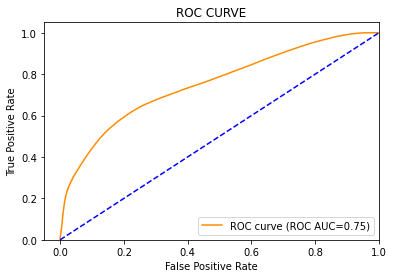

In [20]:
full_test()

In [21]:
for epoch in range(11, 21):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 11 ; Loss: tensor(1.0076, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7549805743143828
Epoch: 12 ; Loss: tensor(0.9710, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7564041066590939
Epoch: 13 ; Loss: tensor(0.9459, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.757269274781993
Epoch: 14 ; Loss: tensor(0.9219, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7579334351035216
Epoch: 15 ; Loss: tensor(0.8956, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.758643981929027
Epoch: 16 ; Loss: tensor(0.8672, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7592010341765093
Epoch: 17 ; Loss: tensor(0.8390, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7590186709554771
Epoch: 18 ; Loss: tensor(0.8128, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7579934569493014
Epoch: 19 ; Loss: tensor(0.7899, grad_fn=<BinaryCrossEntropyWithLo

tensor([ 0.0666,  0.4319,  0.0088,  ...,  0.4245, -0.0031, -0.0181])
precision: 0.32546035881228974 
recall: 0.4469837429363986


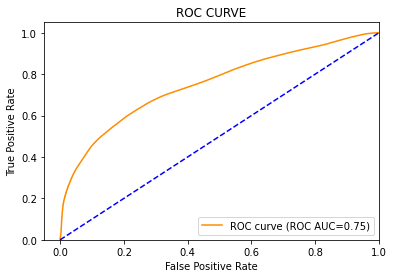

In [23]:
full_test()

In [24]:
model.eval()
model.encode()

tensor([[-0.1433,  0.0097,  0.0989,  ...,  0.2064, -0.0479,  0.1719],
        [-0.0692, -0.0005, -0.0018,  ...,  0.0494, -0.0432,  0.0615],
        [-0.0086,  0.0089, -0.0023,  ...,  0.0052, -0.0084,  0.0424],
        ...,
        [-0.0403, -0.0972,  0.0121,  ...,  0.0717, -0.0172, -0.0785],
        [-0.0096, -0.0365,  0.0252,  ..., -0.0192, -0.0198, -0.0091],
        [-0.0325, -0.1020,  0.0247,  ...,  0.0700, -0.0158, -0.0574]],
       grad_fn=<AddBackward0>)

In [25]:
for epoch in range(21, 26):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 21 ; Loss: tensor(0.7522, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.744047692829638
Epoch: 22 ; Loss: tensor(0.7362, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7333378246254986
Epoch: 23 ; Loss: tensor(0.7222, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7188626137036236
Epoch: 24 ; Loss: tensor(0.7105, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7000721817584457
Epoch: 25 ; Loss: tensor(0.7005, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.6772320776638246


tensor([-0.2166,  0.1704, -0.0507,  ...,  0.1714, -0.0311, -0.0361])
precision: 0.29562585542234016 
recall: 0.29540845016067274


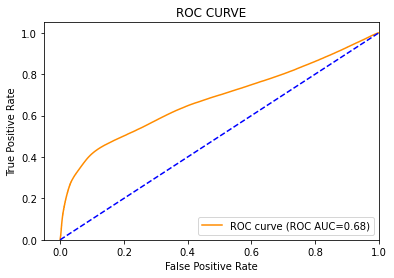

In [26]:
full_test()

In [27]:
model.eval()
z = model.encode()
z

tensor([[-0.0818,  0.0969,  0.0227,  ...,  0.0825,  0.0057,  0.1202],
        [-0.0431,  0.0253, -0.0345,  ...,  0.0001, -0.0253,  0.0443],
        [ 0.0068,  0.0242, -0.0198,  ..., -0.0208,  0.0064,  0.0319],
        ...,
        [-0.0326, -0.0720, -0.0114,  ...,  0.0353, -0.0135, -0.1034],
        [-0.0050, -0.0191,  0.0146,  ..., -0.0523, -0.0300, -0.0461],
        [-0.0284, -0.0783,  0.0078,  ...,  0.0369, -0.0103, -0.0795]],
       grad_fn=<AddBackward0>)

In [28]:
model.decode(z, data.train_pos_edge_index, data.train_neg_edge_index).sigmoid()

tensor([0.5803, 0.5594, 0.6413,  ..., 0.5040, 0.4959, 0.4672],
       grad_fn=<SigmoidBackward0>)

## Alternative Model to fix things

In [15]:
class GNN_homogen_with_data_cached(torch.nn.Module):
    '''
    basic implementation of GNN, inspired by content shown in https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post12.html from Antionio Longa
    '''
    def __init__(self):
        super(GNN_homogen_with_data_cached, self).__init__()
        self.conv1 = GCNConv(data.num_features, int(data.num_features/2), cached=True)
        self.conv2 = GCNConv(int(data.num_features/2), 64, cached = True)
    
    def encode(self):
        x = self.conv1(data.x.relu(), data.train_pos_edge_index) # first convolution layer
        x = x.relu() # relu function for tu - disables negative values
        x = self.conv2(x, data.train_pos_edge_index) # second convolution layer
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) #fuse pos and neg edges together
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1) # dot product of ... getting the mapped entries with z? z=model?
        return logits
    
    def decode_all(self, z):
        prob_adj = z @ z.t() # get adjacenticy matrix NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list # should this not be 0.5?

In [16]:
def train_2():
    model.train()
    optimizer.zero_grad()
    link_logits = model.decode(model.encode(), data.train_pos_edge_index, data.train_neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, data.train_neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels, reduction='sum')
    loss.backward()
    optimizer.step()
    return loss

In [25]:
@torch.no_grad()
def z_test():
    model.eval()
    z = model.encode()
    print(z)
    return

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
data = data_rdkit.to(device)
model = GNN_homogen_with_data_cached().to(device)
optimizer = torch.optim.Adam(params=model.parameters())#, lr=0.01)

In [19]:
for epoch in range(1, 11):
    loss = train_2()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 1 ; Loss: tensor(8.9781e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7242989680075109
Epoch: 2 ; Loss: tensor(6.6856e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7309782417928271
Epoch: 3 ; Loss: tensor(4.8708e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7373643229068805
Epoch: 4 ; Loss: tensor(3.4809e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.741168834513283
Epoch: 5 ; Loss: tensor(2.4565e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7422895928006011
Epoch: 6 ; Loss: tensor(1.7405e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7439112265025393
Epoch: 7 ; Loss: tensor(1.2809e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7461738684772207
Epoch: 8 ; Loss: tensor(1.0185e+08, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7485974582470802
Epoch: 9 ; Loss: tensor(88745320., grad_f

tensor([1.4182, 1.7766, 0.2950,  ..., 1.7239, 0.1113, 0.1064])
precision: 0.339743216406529 
recall: 0.6102018609376372


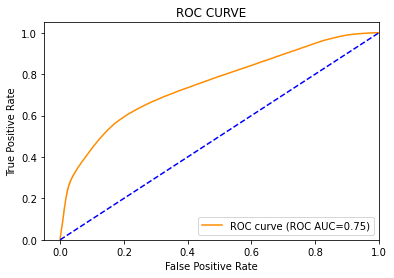

In [24]:
full_test()

In [26]:
z_test()

tensor([[-0.1450,  0.2688,  0.2312,  ..., -0.1882,  0.0748, -0.2233],
        [-0.0480,  0.0495,  0.0916,  ..., -0.0197, -0.0080, -0.0617],
        [-0.0993,  0.0621,  0.0518,  ..., -0.0214, -0.0005, -0.0428],
        ...,
        [-0.1081,  0.0408,  0.0410,  ..., -0.0474,  0.0368, -0.1320],
        [-0.1324,  0.1811,  0.0460,  ..., -0.0894, -0.0805, -0.0610],
        [-0.0852,  0.0256,  0.0416,  ..., -0.0378,  0.0775, -0.1210]])


In [27]:
for epoch in range(11, 21):
    loss = train_2()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

Epoch: 11 ; Loss: tensor(82155712., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7507464775112872
Epoch: 12 ; Loss: tensor(81380080., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7505390308352826
Epoch: 13 ; Loss: tensor(79846944., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7501128650922967
Epoch: 14 ; Loss: tensor(77426520., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7494684374898192
Epoch: 15 ; Loss: tensor(74465088., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7490902712146033
Epoch: 16 ; Loss: tensor(71163768., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7489670001894655
Epoch: 17 ; Loss: tensor(67661136., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7488636254086836
Epoch: 18 ; Loss: tensor(64158672., grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) ; Test ROC AUC: 0.7486202947720062
Epoch: 19 ; Loss: tensor(60847532., grad

tensor([0.3356, 0.5646, 0.0615,  ..., 0.5634, 0.0305, 0.0385])
precision: 0.33422005339150374 
recall: 0.591046048069185


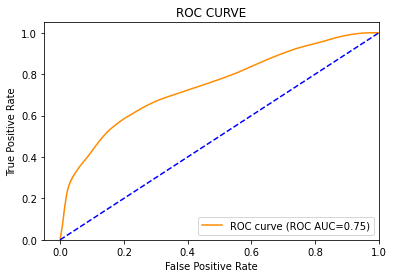

In [28]:
full_test()

In [29]:
z_test()

tensor([[-0.1529,  0.1316,  0.1137,  ...,  0.0548, -0.1824, -0.0795],
        [-0.0508,  0.0233,  0.0478,  ...,  0.0460, -0.0769, -0.0225],
        [-0.0961,  0.0425,  0.0172,  ...,  0.0184, -0.0487, -0.0059],
        ...,
        [-0.0567, -0.0218,  0.0472,  ...,  0.0530, -0.0184, -0.0814],
        [-0.0804,  0.1232,  0.0674,  ...,  0.0496, -0.1660,  0.0133],
        [-0.0334, -0.0411,  0.0474,  ...,  0.0593,  0.0147, -0.0789]])


## Alternative Model using bilinear layer instead of dotproduct for decode

In [13]:
from torch.nn import Bilinear, Flatten

In [14]:
class GNN_homogen_with_data_bil(torch.nn.Module):
    '''
    basic implementation of GNN, inspired by content shown in https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post12.html from Antionio Longa
    '''
    def __init__(self):
        super(GNN_homogen_with_data_bil, self).__init__()
        self.conv1 = GCNConv(data.num_features, int(data.num_features/2))
        self.conv2 = GCNConv(int(data.num_features/2), 64)
        self.bilin = Bilinear(64, 64, 1)
        self.endflat = Flatten(0,-1)
    
    def encode(self):
        x = self.conv1(data.x.relu(), data.train_pos_edge_index) # first convolution layer
        x = x.relu() # relu function for tu - disables negative values
        x = self.conv2(x, data.train_pos_edge_index) # second convolution layer
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) #fuse pos and neg edges together
        logits = self.endflat(self.bilin(z[edge_index[0]], z[edge_index[1]]))
        return logits

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
data = data_rdkit.to(device)
model = GNN_homogen_with_data_bil().to(device)
optimizer = torch.optim.Adam(params=model.parameters())#, lr=0.01)

In [17]:
for epoch in range(1, 6):
    loss = train()
    roc_auc = test()
    print("Epoch:", epoch, "; Loss:", loss, "; Test ROC AUC:", roc_auc)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1091043983360 bytes.

## Beginning of accuracy section

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

In [22]:
def calc_and_plot_ROC_pyg(link_labels, link_logits):
    label_prob = link_logits.sigmoid()
    # use sklearn to get fpr and tpr
    fpr, tpr, _ = metrics.roc_curve(link_labels.detach().numpy(), label_prob.detach().numpy())
    # calculate the roc_auc (area under the curve)
    roc_auc = metrics.auc(fpr, tpr)
    # PLOT THE ROC CURVE
    '''
    Following code inspired/partly copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    '''
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", label="ROC curve (ROC AUC=%0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color="blue", linestyle="--")
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC CURVE")
    plt.legend(loc="lower right")
    plt.show()

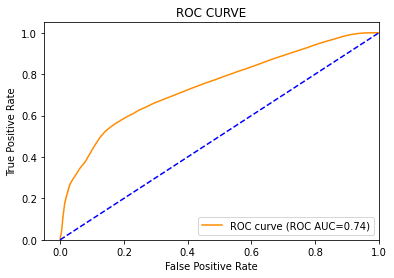

In [74]:
calc_and_plot_ROC_pyg(link_labels, link_logits)

In [23]:
def accuracy_precision_recall_pyg(edge_index, link_labels, link_logits, id_breakpoint):
    # define function for creating precision and recall at k for each user
    def precision_recall_at_k(edge_index, link_labels, link_logits, k, threshold, id_breakpoint):
        # problem with duplicity of edges... fixed with double of simplelib k, then it should result in the same metrics
        user_est_true = defaultdict(list)
        # write user_est_true
        for edge, true_label, pred_label in zip(edge_index.t().detach().numpy(), link_labels.detach().numpy(), link_logits.sigmoid().detach().numpy()):
            user = None
            # determine user. user = experiment
            if edge[0]<id_breakpoint:
                user = edge[0]
            else:
                user = edge[1]
            # write into user_est_true
            user_est_true[user].append((pred_label, true_label))

        # create precisions and recalls dictionary
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls
    # execute precision-recall function and compute average over precision and recall values
    precision_list, recall_list = precision_recall_at_k(edge_index, link_labels, link_logits, 200, 0.5, id_breakpoint)
    p = sum(precision_list.values())/len(precision_list)
    r = sum(recall_list.values())/len(recall_list)
    return p, r

In [10]:
import pandas as pd

In [11]:
edge_index = torch.cat([data.train_pos_edge_index, data.train_neg_edge_index], dim=-1)

In [12]:
edge_index.size()

torch.Size([2, 66592040])

In [13]:
link_logits = link_labels.clone()

In [14]:
temp = pd.DataFrame(np.c_[np.transpose(edge_index.detach().numpy()), link_labels.detach().numpy(), link_logits.sigmoid().detach().numpy()], columns=['id1', 'id2', 'true_label', 'pred_label'])

In [15]:
temp

,id1,id2,true_label,pred_label
0,2119.0,303887.0,1.0,0.731059
1,1020.0,35844.0,1.0,0.731059
2,102.0,258793.0,1.0,0.731059
3,753.0,344510.0,1.0,0.731059
4,1308.0,355446.0,1.0,0.731059
...,...,...,...,...
66592035,349241.0,302.0,0.0,0.500000
66592036,237878.0,769.0,0.0,0.500000
66592037,425314.0,2208.0,0.0,0.500000
66592038,447778.0,152.0,0.0,0.500000


In [ ]:
temp.id1.combine(temp.id2, func=lambda x,y: x+y)

In [89]:
precision, recall = accuracy_precision_recall_pyg(torch.cat([data.train_pos_edge_index, data.train_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)

In [90]:
print("precision:", precision, "\nrecall:", recall)

precision: 0.36884013842343405 
recall: 0.6119862432430785


## Testing it with test data - worst test case (manual testing section)

In [126]:
model.eval()

GNN_homogen_with_data(
  (conv1): GCNConv(205, 102)
  (conv2): GCNConv(102, 64)
)

In [127]:
z = model.encode()

In [128]:
z

tensor([[-0.0330, -0.0004,  0.0117,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        ...,
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610],
        [-0.0330, -0.0004,  0.0116,  ..., -0.0381,  0.0109,  0.0610]],
       grad_fn=<AddBackward0>)

In [129]:
link_logits = model.decode(z, data.test_pos_edge_index, data.test_neg_edge_index)
link_logits

tensor([0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
       grad_fn=<SumBackward1>)

In [130]:
link_probs = link_logits.sigmoid()
link_probs

tensor([0.5093, 0.5092, 0.5092,  ..., 0.5092, 0.5092, 0.5092],
       grad_fn=<SigmoidBackward0>)

In [137]:
link_logits[0]

tensor(0.0370, grad_fn=<SelectBackward0>)

In [131]:
(link_probs<0.5).sum()

tensor(0)

In [132]:
link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

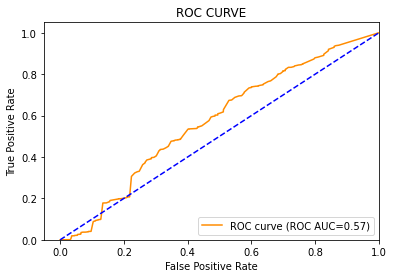

In [133]:
calc_and_plot_ROC_pyg(link_labels, link_logits)

In [134]:
precision, recall = accuracy_precision_recall_pyg(torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)

In [135]:
print("precision:", precision, "\nrecall:", recall)

precision: 0.3608354276867442 
recall: 0.6721041255977497


## Test section 2

In [218]:
model.eval()
z=model.encode()
z

tensor([[-0.1414, -0.1699, -0.0718,  ..., -0.0716, -0.1209, -0.1339],
        [-0.0779, -0.0596, -0.0362,  ..., -0.0012, -0.0550, -0.0735],
        [-0.0961, -0.0153,  0.0493,  ..., -0.0115,  0.0200, -0.0973],
        ...,
        [-0.0266, -0.0262, -0.0494,  ..., -0.0315, -0.0786,  0.0398],
        [ 0.0965,  0.0257, -0.0892,  ..., -0.0850, -0.0207,  0.1184],
        [-0.0029, -0.0178, -0.0322,  ..., -0.0350, -0.0455,  0.0485]],
       grad_fn=<AddBackward0>)

In [219]:
link_logits = model.decode(z, data.test_pos_edge_index, data.test_neg_edge_index)
link_logits.sigmoid()

tensor([0.6867, 0.7601, 0.5345,  ..., 0.7459, 0.5091, 0.5096],
       grad_fn=<SigmoidBackward0>)

In [223]:
(link_logits.sigmoid()<0.5).sum()

tensor(510480)

In [220]:
link_labels = get_link_labels(data.test_pos_edge_index, data.test_neg_edge_index)
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

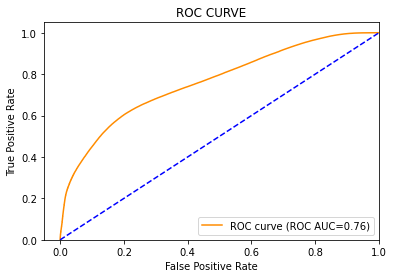

In [221]:
calc_and_plot_ROC_pyg(link_labels, link_logits)

In [222]:
precision, recall = accuracy_precision_recall_pyg(torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1),
                                                 link_labels, link_logits, id_breakpoint)
print("precision:", precision, "\nrecall:", recall)

precision: 0.34207395758778514 
recall: 0.6056583577358485
